<a href="https://colab.research.google.com/github/JuanPesa/PCA-NCOMP-SELECTION/blob/main/PCA_NCOMP_SELECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Cargamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml,load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import time

In [ ]:
# ==============================================================================
# Carga y Preprocesamiento de Datasets
# ==============================================================================
print("Cargando y preprocesando datasets...")

# Cargar dataset MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist = mnist.data.astype('float32') # Asegurarse de que X sea float
y_mnist = mnist.target.astype('int32') # <--- CLAVE: Convertir etiquetas a int32
print(f"MNIST cargado. Forma de X: {X_mnist.shape}, Forma de y: {y_mnist.shape}, dtype de y: {y_mnist.dtype}")

# Cargar dataset Digits
digits = load_digits()
X_digits = digits.data.astype('float32') # Asegurarse de que X sea float
y_digits = digits.target.astype('int32') # <--- CLAVE: Convertir etiquetas a int32
print(f"Digits cargado. Forma de X: {X_digits.shape}, Forma de y: {y_digits.shape}, dtype de y: {y_digits.dtype}")

# Cargar dataset Fashion MNIST (FMNIST)
fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='auto')
X_fmnist = fmnist.data.astype('float32') # Asegurarse de que X sea float
y_fmnist = fmnist.target.astype('int32') # <--- CLAVE: Convertir etiquetas a int32
print(f"Fashion MNIST cargado. Forma de X: {X_fmnist.shape}, Forma de y: {y_fmnist.shape}, dtype de y: {y_fmnist.dtype}")

datasets = {
    'MNIST': (X_mnist, y_mnist),
    'Digits': (X_digits, y_digits),
    'Fashion MNIST': (X_fmnist, y_fmnist)
}

Cargando y preprocesando datasets...
MNIST cargado. Forma de X: (70000, 784), Forma de y: (70000,), dtype de y: int32
Digits cargado. Forma de X: (1797, 64), Forma de y: (1797,), dtype de y: int32
Fashion MNIST cargado. Forma de X: (70000, 784), Forma de y: (70000,), dtype de y: int32


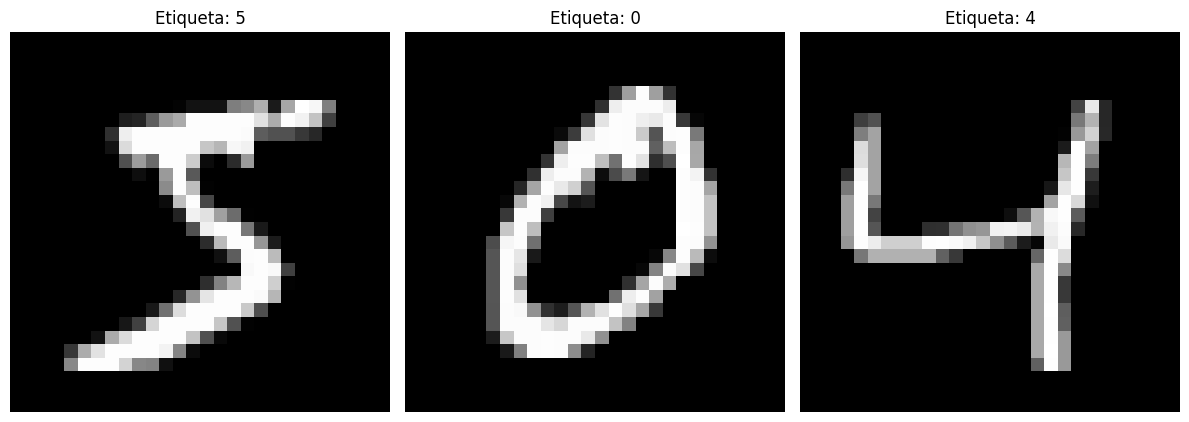

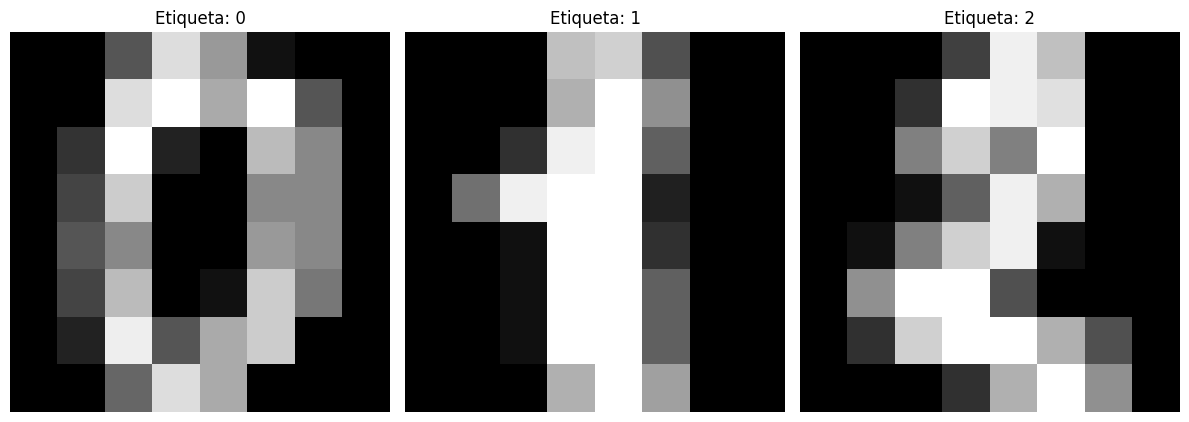

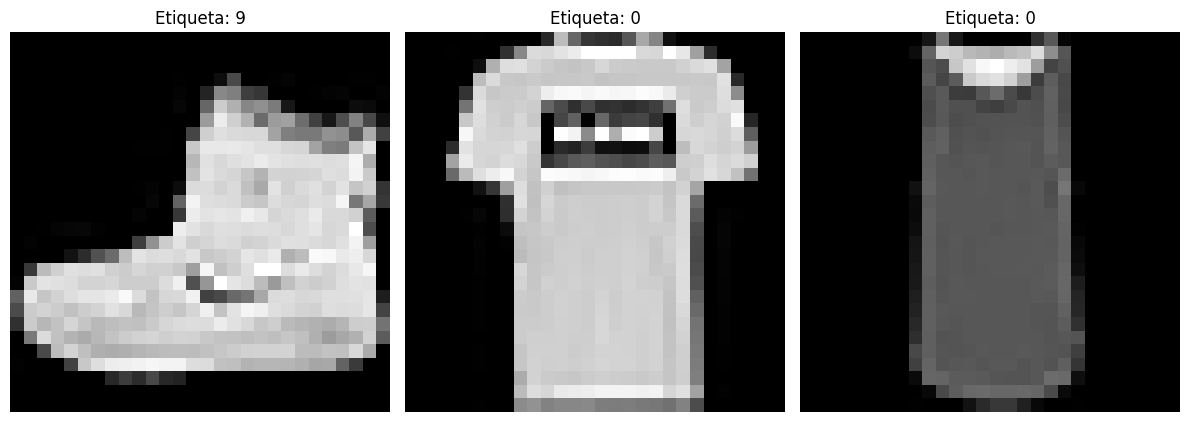

In [ ]:
# ==============================================================================
# Muestra de una foto de cada dataset
# ==============================================================================

#MNIST
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(X_mnist[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Etiqueta: {y_mnist[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

#DIGITS

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(X_digits[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Etiqueta: {y_digits[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

#FASHION MNIST

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(X_fmnist[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Etiqueta: {y_fmnist[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()











In [ ]:
# ==============================================================================
# Definiciones de Funciones de Criterios PCA
# ==============================================================================

def kaiser_criterion(eigenvalues):
    """Aplica el criterio de Kaiser para determinar el número de componentes principales.
    Args:
    eigenvalues: Un array 1D de NumPy con los valores propios (eigenvalues).
    Returns:
    El número de componentes principales a retener según el criterio de Kaiser.
    """
    average_eigenvalue = np.mean(eigenvalues)
    n_components = np.sum(eigenvalues >= average_eigenvalue)
    return n_components

def explained_variance_ratio_criterion(explained_variance_ratio, threshold=0.95):
    """Aplica el criterio de la razón de varianza explicada para determinar el número de componentes principales.
    Args:
    explained_variance_ratio: Un array 1D de NumPy con las razones de varianza explicada.
    threshold: El umbral para la razón de varianza explicada acumulada.
    Returns:
    El número de componentes principales a retener según el criterio de la razón de varianza explicada.
    """
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    return n_components

def parallel_analysis(data, n_replications=5):
    """
    Realiza un análisis paralelo para estimar el número de componentes principales.
    Args:
    data: Un array de NumPy con forma (n_samples, n_features) que representa los datos.
    n_replications: El número de conjuntos de datos aleatorios a generar para la comparación.
    Returns:
    El número estimado de componentes principales.
    """
    n_samples, n_features = data.shape
    pca_real = PCA().fit(data)
    eigenvalues_real = pca_real.explained_variance_

    random_eigenvalues = []
    for _ in range(n_replications):
        random_data = np.random.normal(loc=0, scale=1, size=(n_samples, n_features))
        random_pca = PCA().fit(random_data)
        random_eigenvalues.append(random_pca.explained_variance_)

    random_eigenvalues = np.array(random_eigenvalues)
    mean_random_eigenvalues = np.mean(random_eigenvalues, axis=0)

    max_components = min(n_samples, n_features)
    n_components = np.sum(eigenvalues_real[:max_components] > mean_random_eigenvalues[:max_components])
    return n_components


==================== Procesando MNIST ====================
Calculando criterios de PCA para MNIST...
   - Características originales: 784
   - Criterio de Kaiser: 179 componentes
   - Varianza Acumulada (umbral 0.95): 332 componentes
   - Ejecutando Análisis Paralelo (puede tomar tiempo)...
   - Análisis Paralelo de Horn: 150 componentes

--- Evaluando Red Densa con diferentes # de componentes PCA para MNIST ---

Entrenando para: Todas las Características (784 componentes)
   Forma de datos de entrenamiento PCA: (56000, 784)
   Forma de datos de prueba PCA: (14000, 784)
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.
   Tiempo de entrenamiento: 69.06 segundos.
   Precisión final en el conjunto de prueba para MNIST (Todas las Características): 0.9668


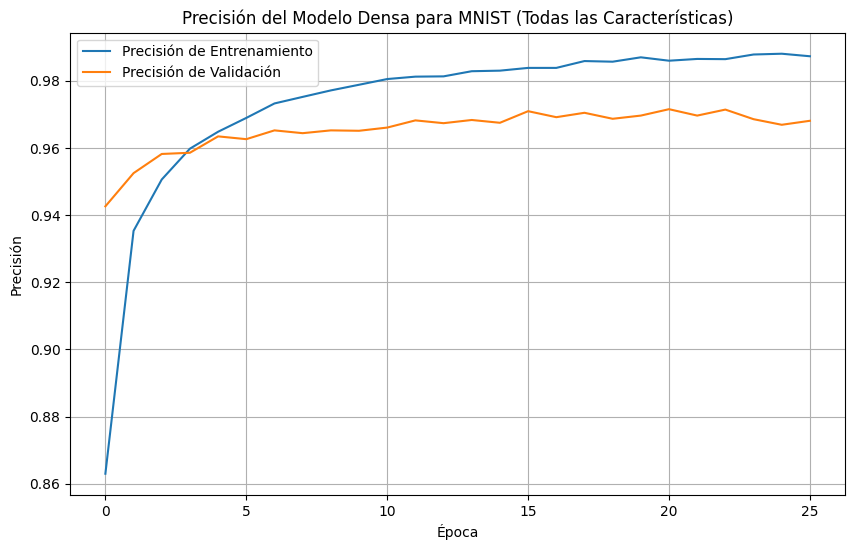


Entrenando para: Mitad de Características (392 componentes)
   Forma de datos de entrenamiento PCA: (56000, 392)
   Forma de datos de prueba PCA: (14000, 392)
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.
   Tiempo de entrenamiento: 42.45 segundos.
   Precisión final en el conjunto de prueba para MNIST (Mitad de Características): 0.9699


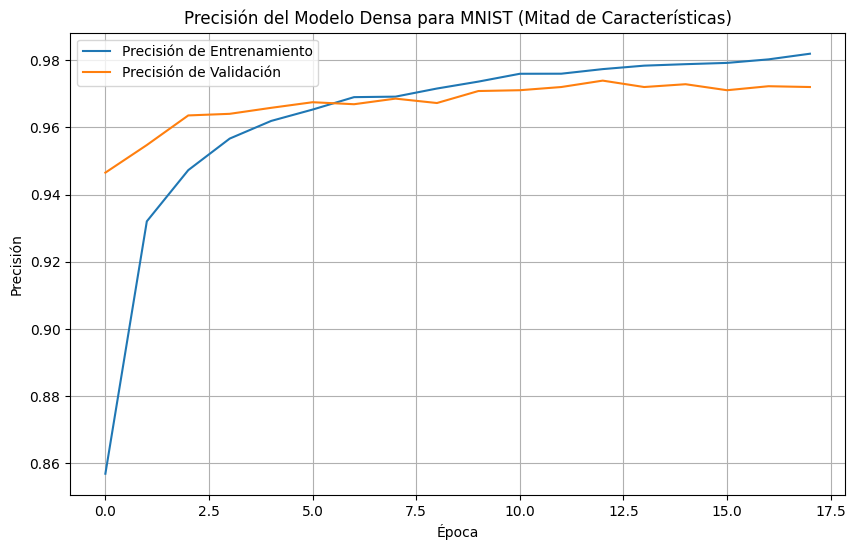


Entrenando para: Kaiser (179 componentes)
   Forma de datos de entrenamiento PCA: (56000, 179)
   Forma de datos de prueba PCA: (14000, 179)
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.
   Tiempo de entrenamiento: 59.22 segundos.
   Precisión final en el conjunto de prueba para MNIST (Kaiser): 0.9742


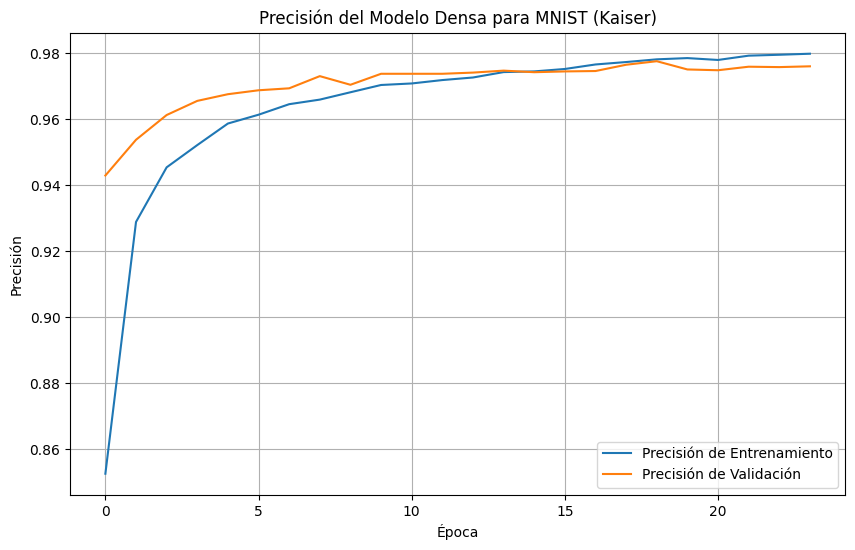


Entrenando para: Varianza Explicada (95%) (332 componentes)
   Forma de datos de entrenamiento PCA: (56000, 332)
   Forma de datos de prueba PCA: (14000, 332)
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.
   Tiempo de entrenamiento: 70.56 segundos.
   Precisión final en el conjunto de prueba para MNIST (Varianza Explicada (95%)): 0.9734


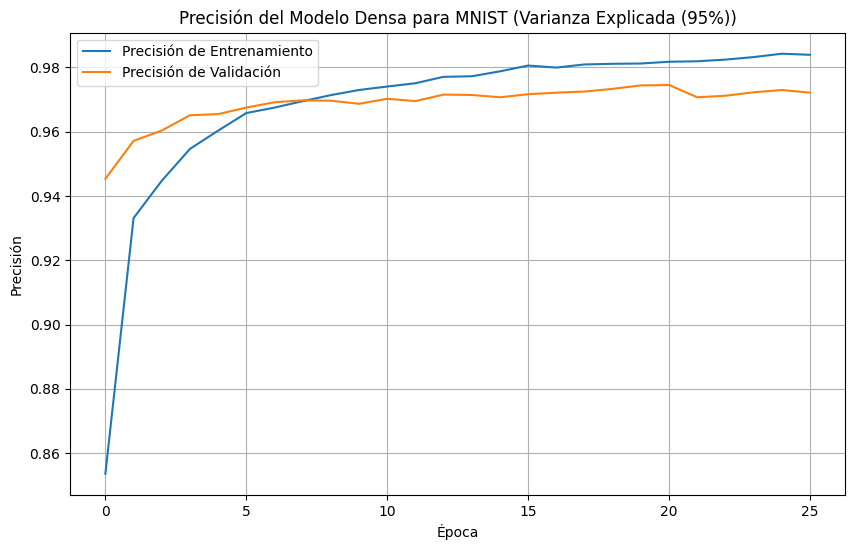


Entrenando para: Análisis Paralelo (150 componentes)
   Forma de datos de entrenamiento PCA: (56000, 150)
   Forma de datos de prueba PCA: (14000, 150)
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.
   Tiempo de entrenamiento: 70.16 segundos.
   Precisión final en el conjunto de prueba para MNIST (Análisis Paralelo): 0.9761


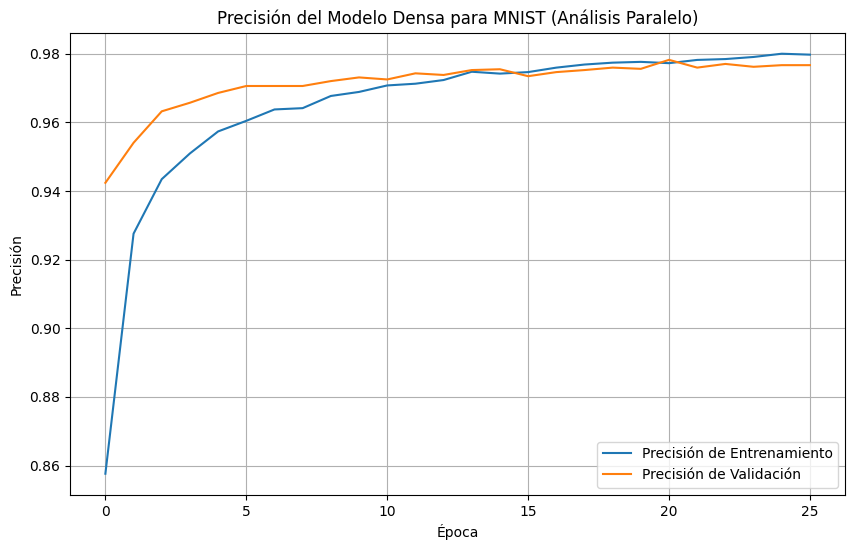




==================== Procesando Digits ====================
Calculando criterios de PCA para Digits...
   - Características originales: 64
   - Criterio de Kaiser: 19 componentes
   - Varianza Acumulada (umbral 0.95): 40 componentes
   - Ejecutando Análisis Paralelo (puede tomar tiempo)...
   - Análisis Paralelo de Horn: 16 componentes

--- Evaluando Red Densa con diferentes # de componentes PCA para Digits ---

Entrenando para: Todas las Características (64 componentes)
   Forma de datos de entrenamiento PCA: (1437, 64)
   Forma de datos de prueba PCA: (360, 64)
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
   Tiempo de entrenamiento: 7.60 segundos.
   Precisión final en el conjunto de prueba para Digits (Todas las Características): 0.9750


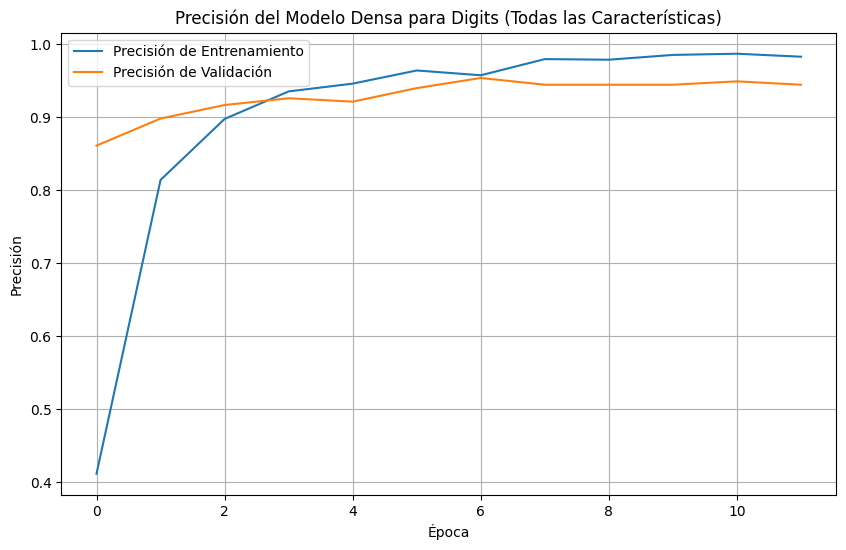


Entrenando para: Mitad de Características (32 componentes)
   Forma de datos de entrenamiento PCA: (1437, 32)
   Forma de datos de prueba PCA: (360, 32)
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
   Tiempo de entrenamiento: 5.53 segundos.
   Precisión final en el conjunto de prueba para Digits (Mitad de Características): 0.9639


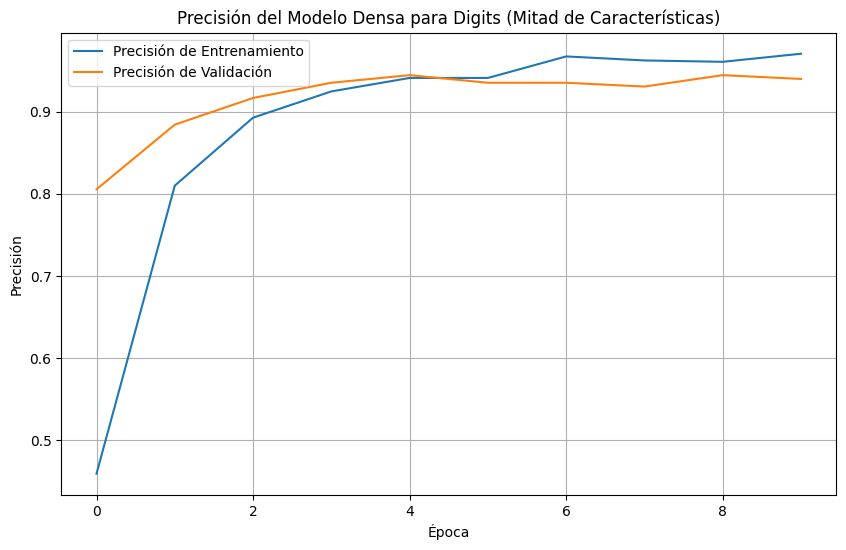


Entrenando para: Kaiser (19 componentes)
   Forma de datos de entrenamiento PCA: (1437, 19)
   Forma de datos de prueba PCA: (360, 19)
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
   Tiempo de entrenamiento: 6.82 segundos.
   Precisión final en el conjunto de prueba para Digits (Kaiser): 0.9583


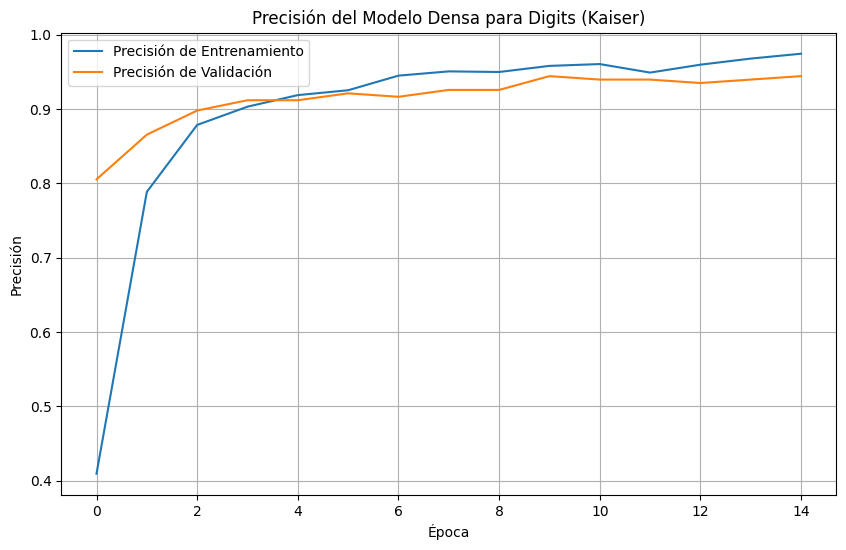


Entrenando para: Varianza Explicada (95%) (40 componentes)
   Forma de datos de entrenamiento PCA: (1437, 40)
   Forma de datos de prueba PCA: (360, 40)
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.
   Tiempo de entrenamiento: 8.79 segundos.
   Precisión final en el conjunto de prueba para Digits (Varianza Explicada (95%)): 0.9778


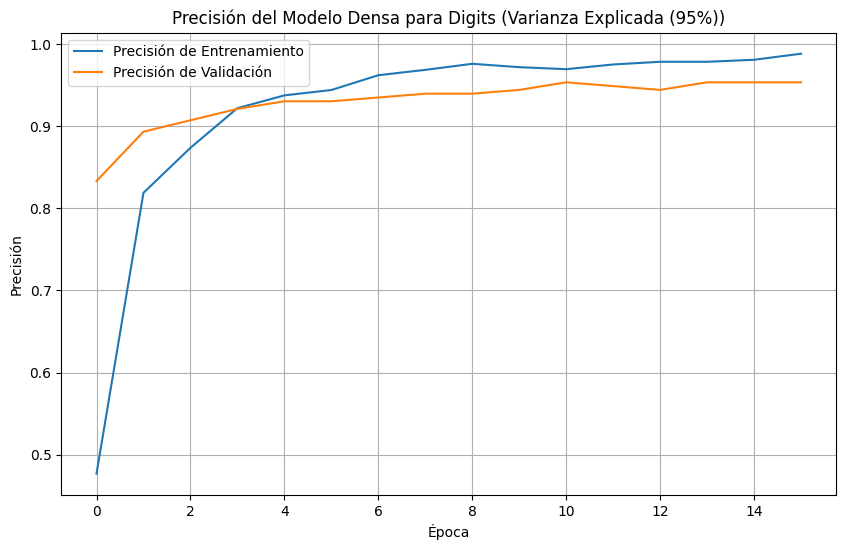


Entrenando para: Análisis Paralelo (16 componentes)
   Forma de datos de entrenamiento PCA: (1437, 16)
   Forma de datos de prueba PCA: (360, 16)
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
   Tiempo de entrenamiento: 8.29 segundos.
   Precisión final en el conjunto de prueba para Digits (Análisis Paralelo): 0.9611


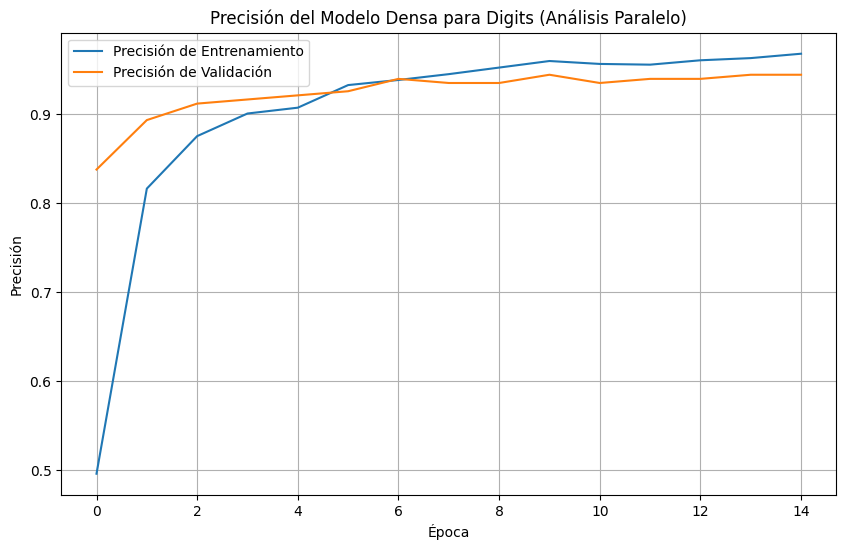




==================== Procesando Fashion MNIST ====================
Calculando criterios de PCA para Fashion MNIST...
   - Características originales: 784
   - Criterio de Kaiser: 79 componentes
   - Varianza Acumulada (umbral 0.95): 256 componentes
   - Ejecutando Análisis Paralelo (puede tomar tiempo)...
   - Análisis Paralelo de Horn: 69 componentes

--- Evaluando Red Densa con diferentes # de componentes PCA para Fashion MNIST ---

Entrenando para: Todas las Características (784 componentes)
   Forma de datos de entrenamiento PCA: (56000, 784)
   Forma de datos de prueba PCA: (14000, 784)
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.
   Tiempo de entrenamiento: 70.31 segundos.
   Precisión final en el conjunto de prueba para Fashion MNIST (Todas las Características): 0.8893


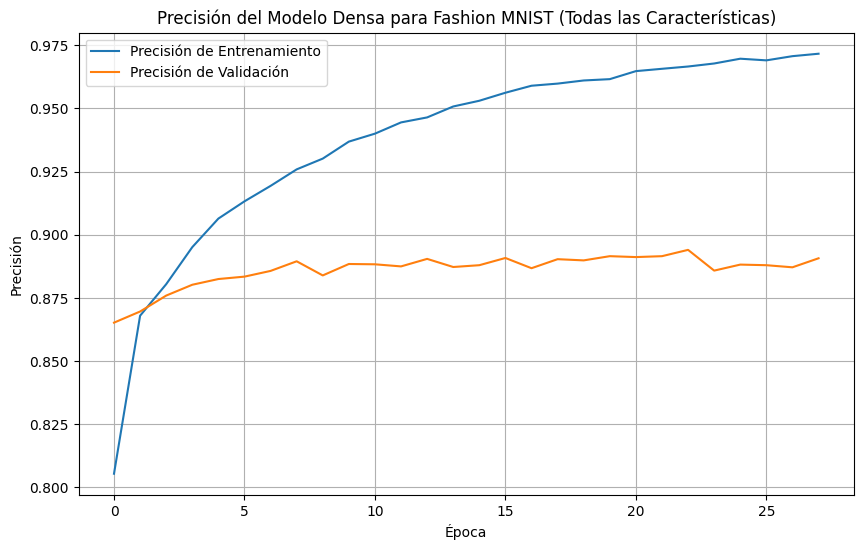


Entrenando para: Mitad de Características (392 componentes)
   Forma de datos de entrenamiento PCA: (56000, 392)
   Forma de datos de prueba PCA: (14000, 392)
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
   Tiempo de entrenamiento: 35.55 segundos.
   Precisión final en el conjunto de prueba para Fashion MNIST (Mitad de Características): 0.8925


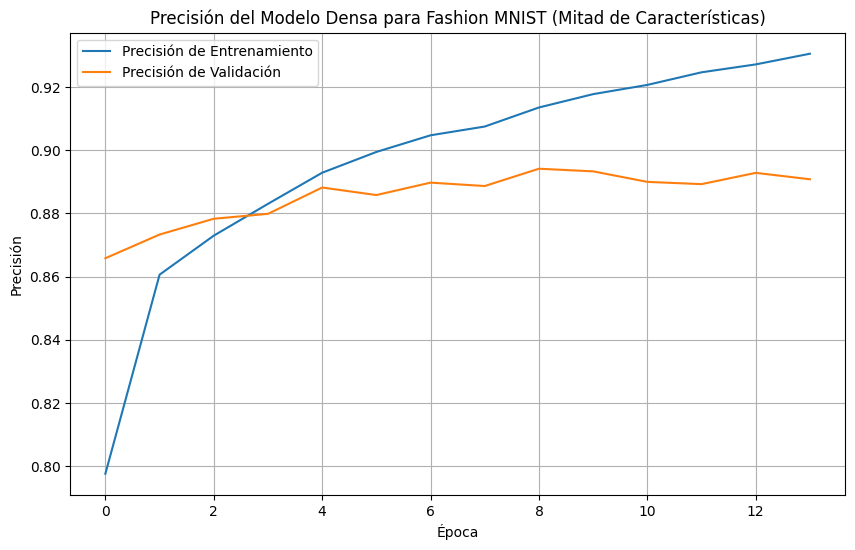


Entrenando para: Kaiser (79 componentes)
   Forma de datos de entrenamiento PCA: (56000, 79)
   Forma de datos de prueba PCA: (14000, 79)
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.
   Tiempo de entrenamiento: 87.46 segundos.
   Precisión final en el conjunto de prueba para Fashion MNIST (Kaiser): 0.8917


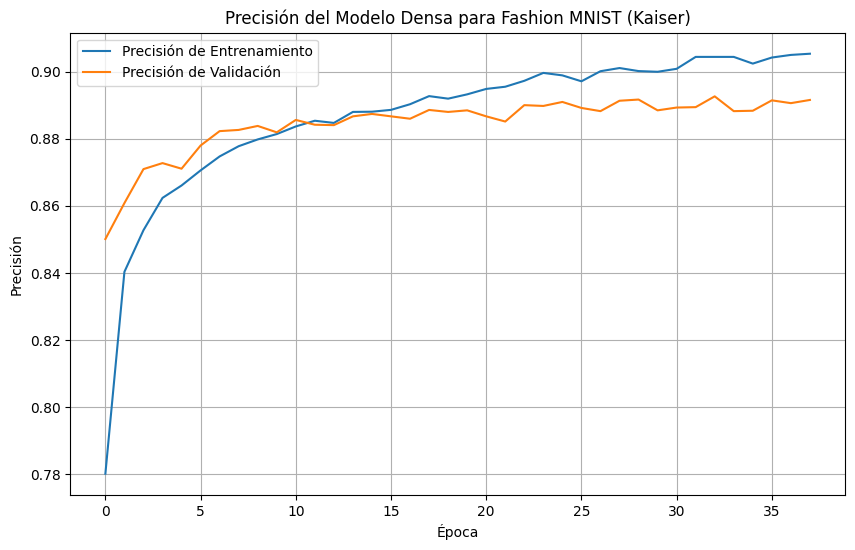


Entrenando para: Varianza Explicada (95%) (256 componentes)
   Forma de datos de entrenamiento PCA: (56000, 256)
   Forma de datos de prueba PCA: (14000, 256)
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
   Tiempo de entrenamiento: 43.95 segundos.
   Precisión final en el conjunto de prueba para Fashion MNIST (Varianza Explicada (95%)): 0.8955


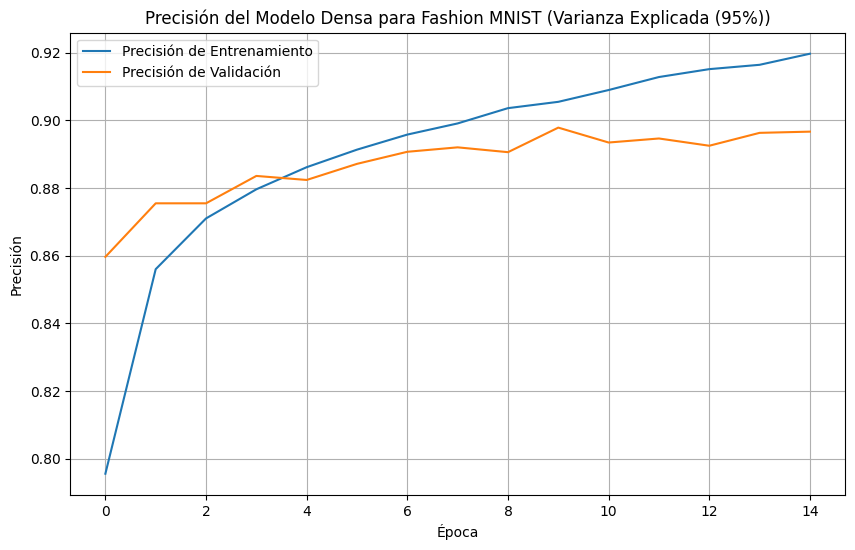


Entrenando para: Análisis Paralelo (69 componentes)
   Forma de datos de entrenamiento PCA: (56000, 69)
   Forma de datos de prueba PCA: (14000, 69)
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.
   Tiempo de entrenamiento: 60.10 segundos.
   Precisión final en el conjunto de prueba para Fashion MNIST (Análisis Paralelo): 0.8883


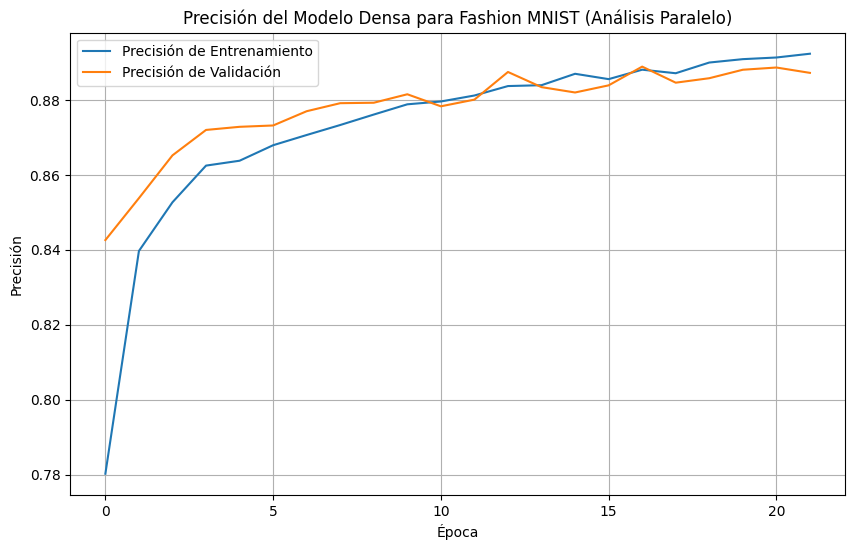




--- Generando gráficas de Precisión de Validación Combinada ---


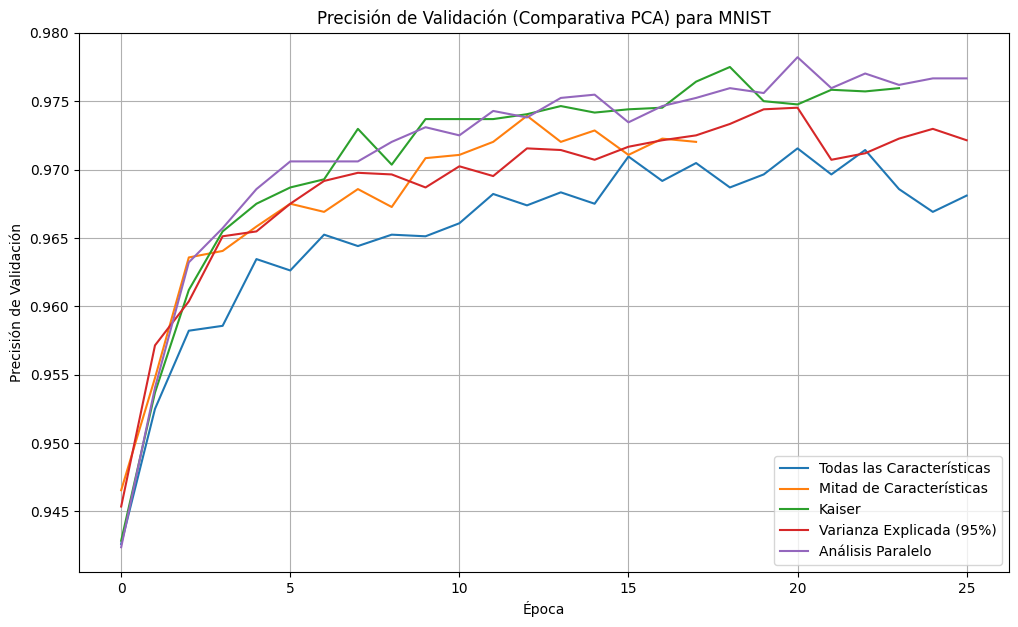

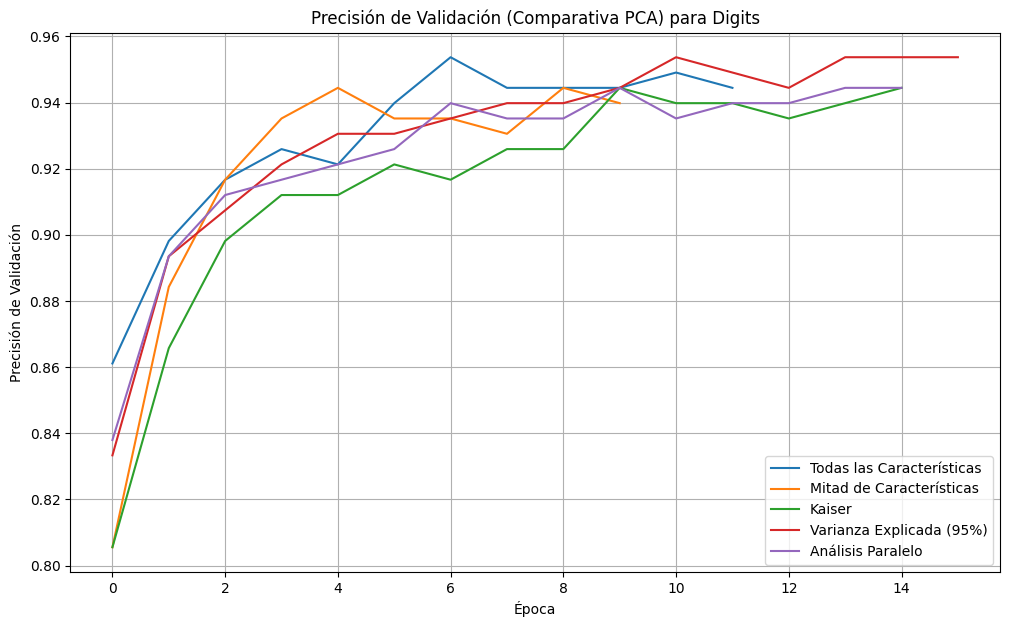

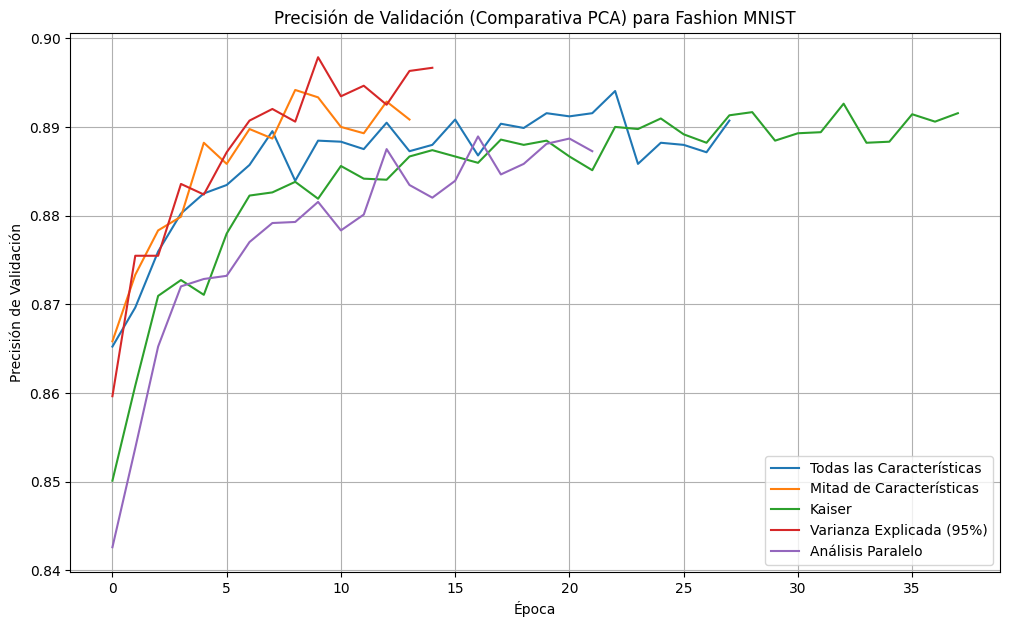

In [ ]:

# ==============================================================================
# Bucle Principal para PCA y Entrenamiento de Red Densa
# ==============================================================================

# Variable para guardar datos de los entrenamientos
all_histories = {}

for dataset_name, (X, y) in datasets.items():
    print(f"\n{'='*20} Procesando {dataset_name} {'='*20}")
    print(f"Calculando criterios de PCA para {dataset_name}...")

    # Guardar historial
    dataset_histories = {}

    # Escalar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA (solo fit para obtener explained_variance_)
    pca = PCA()
    pca.fit(X_scaled)

    original_features = X_scaled.shape[1]
    print(f"   - Características originales: {original_features}")

    n_components_kaiser = kaiser_criterion(pca.explained_variance_)
    print(f"   - Criterio de Kaiser: {n_components_kaiser} componentes")

    n_components_evr = explained_variance_ratio_criterion(pca.explained_variance_ratio_)
    print(f"   - Varianza Acumulada (umbral 0.95): {n_components_evr} componentes")

    print("   - Ejecutando Análisis Paralelo (puede tomar tiempo)...")
    n_components_pa = parallel_analysis(X_scaled)
    print(f"   - Análisis Paralelo de Horn: {n_components_pa} componentes")

    n_components_options = {
        'Todas las Características': original_features,
        'Mitad de Características': int(original_features / 2),
        'Kaiser': n_components_kaiser,
        'Varianza Explicada (95%)': n_components_evr,
        'Análisis Paralelo': n_components_pa,

    }

    # Asegurarse de que los n_components no excedan el número de características originales
    # y que sean al menos 1. Esta sección estaba comentada, pero es importante.
    #for criterion_name, n_comps in n_components_options.items():
    #   n_components_options[criterion_name] = max(1, min(n_comps, original_features))


    print(f"\n--- Evaluando Red Densa con diferentes # de componentes PCA para {dataset_name} ---")

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    for criterion_name, n_components in n_components_options.items():
        print(f"\nEntrenando para: {criterion_name} ({n_components} componentes)")

        pca_applied = PCA(n_components=n_components)
        X_pca_transformed = pca_applied.fit_transform(X_scaled)

        X_train_pca, X_test_pca, y_train, y_test = train_test_split(
            X_pca_transformed, y, test_size=0.2, random_state=42
        )
        print(f"   Forma de datos de entrenamiento PCA: {X_train_pca.shape}")
        print(f"   Forma de datos de prueba PCA: {X_test_pca.shape}")

        num_classes = len(np.unique(y))

        model_dense = models.Sequential([
            layers.Input(shape=(n_components,)),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation='softmax')
        ])

        model_dense.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

        # --- Iniciar el cronómetro ---
        start_time = time.time()

        history = model_dense.fit(X_train_pca, y_train,
                                  epochs=100,
                                  batch_size=64,
                                  validation_split=0.15,
                                  verbose=0, # Keep verbose=0 for cleaner output during training
                                  callbacks=[early_stopping])

        # --- Detener el cronómetro y calcular la duración ---
        end_time = time.time()
        training_duration = end_time - start_time
        print(f"   Tiempo de entrenamiento: {training_duration:.2f} segundos.")

        loss, accuracy = model_dense.evaluate(X_test_pca, y_test, verbose=0)
        print(f"   Precisión final en el conjunto de prueba para {dataset_name} ({criterion_name}): {accuracy:.4f}")

        # Store the history for combined plotting later
        dataset_histories[criterion_name] = history

        # --- Plot individual accuracy (as you had it) ---
        plt.figure(figsize=(10, 6))
        if 'accuracy' in history.history and 'val_accuracy' in history.history:
            plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
            plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
        elif 'acc' in history.history and 'val_acc' in history.history:
            plt.plot(history.history['acc'], label='Precisión de Entrenamiento')
            plt.plot(history.history['val_acc'], label='Precisión de Validación')
        else:
            print(f"   Advertencia: No se encontraron métricas 'accuracy' o 'acc' en el historial de entrenamiento para {criterion_name}.")

        plt.title(f'Precisión del Modelo Densa para {dataset_name} ({criterion_name})')
        plt.ylabel('Precisión')
        plt.xlabel('Época')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Almacenamos los datos de cada entreno
    all_histories[dataset_name] = dataset_histories

    print("\n" + "=" * 60 + "\n") # Separador grande entre datasets

# ==============================================================================
# Graficas
# ==============================================================================

print("\n--- Generando gráficas de Precisión de Validación Combinada ---")
for dataset_name, histories_dict in all_histories.items():
    plt.figure(figsize=(12, 7))
    plt.title(f'Precisión de Validación (Comparativa PCA) para {dataset_name}')
    plt.ylabel('Precisión de Validación')
    plt.xlabel('Época')
    plt.grid(True)

    has_data_to_plot = False
    for criterion_name, history in histories_dict.items():
        val_metric_key = None
        if 'val_accuracy' in history.history:
            val_metric_key = 'val_accuracy'
        elif 'val_acc' in history.history:
            val_metric_key = 'val_acc'

        if val_metric_key:
            plt.plot(history.history[val_metric_key], label=f'{criterion_name}')
            has_data_to_plot = True
        else:
            print(f"   Advertencia: No se encontraron métricas de validación 'val_accuracy' o 'val_acc' para {dataset_name} ({criterion_name}).")

    if has_data_to_plot:
        plt.legend(loc='lower right')
        plt.show()
    else:
        print(f"No hay datos de precisión de validación para plotear para {dataset_name}.")
